In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display

# The port graph model

We use a graph data model where nodes represent sequence segments, and edges indicate how multiple segments can be joined together. More specifically, we use a "port graph" in which each node is accessed via ports that correspond to nucleotide positions on the source sequence. This allows pairs of edges to reference subsequences without having to split up existing nodes. The port information is stored on the edges, which specify 'to' and 'from' positions in addition to the source and target node.

The actual sequences are stored with their hashes in a database table that may contain metadata on where to find the source sequence (drive, url, ...), but lacks any biological context. Sequence nodes are instantiations of source sequences, they do not have to be unique and are well suited to carry metadata. They are referenced by an identifier that is unique within the graph, which avoids creating ambiguous edges or cycles.

In [2]:
# Create an empty graph
G = nx.DiGraph()

# For the sake of this example, we don't calculate the hash and use a simple dictionary.
sequence_hashes = {'h1': 'ABCDEFGHIJ', 
                   'h2': 'KL', 
                   'h3': 'M'}

# Define the starting sequence node via its hash, and use an integer as node identifier for now.
G.add_node(1,  sequence_hash = 'h1')

A sequence variant or edit is represented by edges and sequence nodes, we demonstrate this first for a substitution. In this case we replace the subsequence DEF by KL.

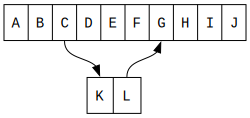

In [3]:
# Add a new sequence node to represent the insert
G.add_node(2, sequence_hash='h2')

# Define port-aware edges by coordinates in the form of: (source node, from position), (target node, to position)
def add_port_edge(graph, source, target):
    # We use edge attributes to store the port information:
    graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

# We add two edges between nodes 1 and 2
add_port_edge(G, (1, 2), (2, 0)) # From node 1, position 2 to node 2, position 0
add_port_edge(G, (2, 1), (1, 6)) # From node 2, position 1 to node 1, position 6

# Let's plot the graph
def draw_port_graph(graph):
    # Create a copy of the graph to avoid modifying the original
    graph = graph.copy()
    
    # Add the actual sequence as node label
    for node in graph.nodes:
        seq = sequence_hashes[graph.nodes[node]['sequence_hash']]
        # Break up the sequence into nucleotides and port markers for graphviz
        label = '|'.join(f'<{i}> {c}' for i, c in enumerate(seq))
        graph.nodes[node]['label'] = label
        # The record node type supports ported nodes
        graph.nodes[node]['shape'] = 'record'
        graph.nodes[node]['fontname'] = 'Courier'

    for edge in graph.edges:
        # Connect the head and tail of each edge to the correct port
        graph.edges[edge]['headport'] = f"{graph.edges[edge]['to_pos']}"
        graph.edges[edge]['tailport'] = f"{graph.edges[edge]['from_pos']}"

    # Convert the networkx graph to a pygraphviz graph
    graph = nx.nx_agraph.to_agraph(graph)

    # Draw the graph using pygraphviz
    fig = SVG(graph.draw(prog='dot', args='-Grankdir=TD -Gsplines=true -Goverlap=scale', format='svg'))
    display(fig)

draw_port_graph(G)


We do the same for an insertion of M between G and H:

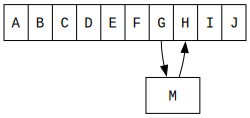

In [4]:
# Restore the same starting sequence
G = nx.DiGraph()
G.add_node(1, sequence_hash = 'h1')

# Add the insert node and two edges
G.add_node(2, sequence_hash='h3')
add_port_edge(G, (1, 6), (2, 0)) # From node 1, position 6 to node 2, position 0
add_port_edge(G, (2, 0), (1, 7)) # From node 2, position 0 to node 2, position 7

draw_port_graph(G)

A deletion of I is represented by just one edge:

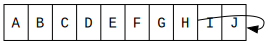

In [5]:
# Restore the same starting sequence
G = nx.DiGraph()
G.add_node(1, sequence_hash = 'h1')

# Delete position 8 to 9
add_port_edge(G, (1, 7), (1, 9)) 

draw_port_graph(G)

In each case, the original source sequence is still present in the graph since we don't break up existing nodes. The advantage of this is that operations are easy to combine as the edges are additive:

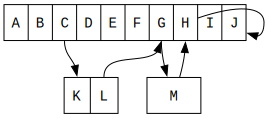

In [6]:
# Starting sequence
G = nx.DiGraph()
G.add_node(1,  sequence_hash = 'h1')

# Substitution
G.add_node(2, sequence_hash='h2')
add_port_edge(G, (1, 2), (2, 0))
add_port_edge(G, (2, 1), (1, 6))

# Insertion
G.add_node(3, sequence_hash='h3')
add_port_edge(G, (1, 6), (3, 0)) 
add_port_edge(G, (3, 0), (1, 7)) 

# Deletion
add_port_edge(G, (1, 7), (1, 9)) 

draw_port_graph(G)

# The segment graph model
The port graph as described above is an efficient way to represent and combine many operations, but it is less intuitive compared to a pangenome graph where each node is a distinct segment. The latter form is used in the GFA file format, which is what graph aware sequence aligners tend to expect. That being said, we can convert a port graph into a segment graph and vice versa without loss of information.

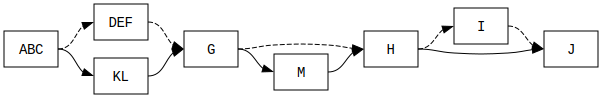

In [7]:
# Create a new graph to store the split nodes
port_graph = G.copy()
segment_graph = nx.DiGraph()

# Set up a simple generator to create unique segment identifiers
def integer_generator():
    i = 0
    while True:
        yield i
        i += 1
index_generator = integer_generator()

# Iterate over all nodes in the graph and split them into segments
for node in port_graph.nodes:
    # Get ports from incoming and outgoing edges
    in_ports = [data['to_pos'] for source, target, data in port_graph.in_edges(node, data=True)]
    out_ports = [data['from_pos'] for source, target, data in port_graph.out_edges(node, data=True)]

    # Get the sequence length via the hash (TODO: store the length in the node attributes so I don't need the sequence here)
    # Note that the hash is already stored in the port graph representation, so you could query it from there too, but then you always need both graphs.
    sequence_hash = port_graph.nodes[node]['sequence_hash']
    sequence_length = len(sequence_hashes[sequence_hash])

    # New segments are defined by the port node identifier, and a start and end position on the sequence the port node references.
    # Each "in port" needs to be present as a segment start, and each "out port" as a segment end.
    # All in ports are preceded by a segment end, an all out ports are followed by a segment start.
    # Position 0 and the last position are always segment starts and ends, respectively.

    starts = sorted(set([0] + in_ports + [x+1 for x in out_ports if x < (sequence_length-1)]))
    ends = sorted(set(out_ports + [sequence_length-1] + [x-1 for x in in_ports if x > 0])) 

    # Create the segments
    segments = []
    for i, j in zip(starts, ends):
        segment_index = next(index_generator)
        segment_graph.add_node(segment_index, sequence_node=node, sequence_hash = sequence_hash, start=i, end=j)
        segments.append(segment_index)

    # Create new edges between the segments to represent the reference sequence
    for i, j in zip(segments[:-1], segments[1:]):
        segment_graph.add_edge(i, j, reference=True)

# Iterate over all the edges in the original graph and create new non-reference edges in the segment graph
for source, target, port_data in port_graph.edges(data=True):
    source_end = port_data['from_pos']
    target_start = port_data['to_pos']
    
    source_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['sequence_node'] == source and segment_data['end'] == source_end]
    target_segments = [node for node, segment_data in segment_graph.nodes(data=True) if segment_data['sequence_node'] == target and segment_data['start'] == target_start]
    assert len(source_segments) == 1
    
    assert len(target_segments) == 1

    segment_graph.add_edge(source_segments[0], target_segments[0], reference=False)

def draw_segment_graph(graph):
    # Create a copy of the graph to avoid modifying the original
    graph = graph.copy()
    
    # Add the actual sequence as node label
    for node in graph.nodes:
        start = graph.nodes[node]['start']
        end = graph.nodes[node]['end']
        seq = sequence_hashes[graph.nodes[node]['sequence_hash']][start:end+1]
        graph.nodes[node]['label'] = seq

        # The record node type supports ported nodes
        graph.nodes[node]['shape'] = 'rectangle'
        graph.nodes[node]['fontname'] = 'Courier'

    for edge in graph.edges:
        # Connect the head and tail of each edge to the left and right side of the nodes
        graph.edges[edge]['headport'] = 'w'
        graph.edges[edge]['tailport'] = 'e'
        # Draw the reference edges as dashed lines
        if graph.edges[edge]['reference']:
            graph.edges[edge]['style'] = 'dashed'

    # Convert the networkx graph to a pygraphviz graph
    graph = nx.nx_agraph.to_agraph(graph)

    # Draw the graph using pygraphviz
    fig = SVG(graph.draw(prog='dot', args='-Grankdir=LR ', format='svg'))
    display(fig)

draw_segment_graph(segment_graph)



In the figure above dashed lines indicate edges that represent the reference sequence. These are not made explicit in the port graph model, so be careful to not store data on these edges unless it can be derived from the other edges in the port model (e.g. frequency = 1 - sum(neighboring edges)).